In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
import keras
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import Sequential
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import AttentionLayer as Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix,getSpansByToxicWords, clean_str
from test_sentence import vectorize, preprocess_lstm, test_attention, test_attention_2
import sklearn


In [2]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 40    # maximum number of letters in sentence?
EMBED_SIZE = 300  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
data = train_data_semeval.load_data("data/tsd_train.csv")
train_df_preprocessed = train_data_semeval.preprocess()

# extra_train = JigsawData(MAX_WORD_NUM)
# extra_train.load_data("data/train.csv")
# extra_df_preprocessed = extra_train.preprocess()


In [5]:
# print(train_df_preprocessed)
# print(train_data_semeval.get_classes_amount(train_df_preprocessed))
# ##add data 
# additional_data = extra_train.get_missing_class_elements(extra_df_preprocessed, 500, 0.0)
# print(additional_data)
# frames = [train_df_preprocessed, additional_data]
# train_df_preprocessed = pd.concat(frames)
# # train_df_preprocessed
# print(train_data_semeval.get_classes_amount(train_df_preprocessed))

In [6]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }
print(train_data)

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###


{'sentence': ['another violent and aggressive immigrant killing a innocent and intelligent us citizen.... sarcasm', 'i am 56 years old, i am not your fucking junior pal.', 'what you are saying makes no sense.', 'i dont know what you are basing this on.', 'the cheap black market crap is still coming up from mexican nationals, and the good stuff from bc and humbolt.', 'the i5 corridor is still just as busy, and they are still making a ton of money.', 'nothing has really changed except that the legal market has made it easy for anyone of legal age to buy it.', 'and the legal market is controlled by corporate growers with million dollar facilities, or a co-op of smaller growers.', 'the federal government war on drugs really has no impact on the legal market in oregon.', 'i dont see any glutton of weed, whatever that means.', 'damn, a whole family.', 'sad indeed.', 'what a knucklehead.', 'how can anyone not know this would be offensive?', '?', 'who do you think should do the killing?', 'any

In [7]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [8]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]

In [9]:
#filter stop words- bez nich wyniki sie wiele nie roznia, a jest trudniej interpretowac- do przemyslenia
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# for i, w in enumerate(sentences):
#     sentences[i] = [w for w in sentences[i] if not w in stop_words]

In [10]:
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts

In [11]:
import gensim
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [12]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [13]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        absent_words+=1

In [14]:
### save toknizer to file so that it could be used again
import pickle

# saving

with open('tokenizer_nn.pickle', 'wb') as handle:

   pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [16]:
sentences = [x for x in sentences if x!=[]]

In [17]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[ 117 1261    3 3170 2045  394    4  776    3  994   74 1059 3515    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  13  181  130  244   13  181   15   22  777 2669 1412    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  25    7   10  265  218   35  492    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  13   50   72   25    7   10 9777   14   20    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 1368  224  727  161    6  154  418   51   46 2907 9778    3    1
    97  506   46  864    3 9779    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [18]:
model = Sequential()

model.add(Embedding(len(word_index)+1 ,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding'))
# model.add(Input(shape=MAX_WORD_NUM, dtype='float32', name='input'))
model.add(Bidirectional(LSTM(40, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional'))

model.add(Dense(80, kernel_regularizer=l2_reg, name='dense'))
model.add(Dropout(0.2))
model.add(Attention(name='attention'))
model.add(Dense(1, activation='sigmoid', name='dense_final')) ##softmax, elu?

model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model_embeddings.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           5542800   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 80)            109120    
_________________________________________________________________
dense (Dense)                (None, 40, 80)            6480      
_________________________________________________________________
dropout (Dropout)            (None, 40, 80)            0         
_________________________________________________________________
attention (AttentionLayer)   (None, 80)                8200      
_________________________________________________________________
dense_final (Dense)          (None, 1)                 81        
Total params: 5,666,681
Trainable params: 5,666,681
Non-trainable params: 0
______________________________________________

Epoch 1/5
85/85 [==============================] - 13s 156ms/step - loss: 0.4737 - acc: 0.7817 - val_loss: 0.3991 - val_acc: 0.8394
Epoch 2/5
85/85 [==============================] - 12s 145ms/step - loss: 0.3864 - acc: 0.8397 - val_loss: 0.3835 - val_acc: 0.8390
Epoch 3/5
85/85 [==============================] - 12s 140ms/step - loss: 0.3472 - acc: 0.8589 - val_loss: 0.4138 - val_acc: 0.8337
Epoch 4/5
85/85 [==============================] - 12s 137ms/step - loss: 0.3101 - acc: 0.8751 - val_loss: 0.4224 - val_acc: 0.8264
Epoch 5/5
85/85 [==============================] - 12s 141ms/step - loss: 0.2692 - acc: 0.8969 - val_loss: 0.4657 - val_acc: 0.8109
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


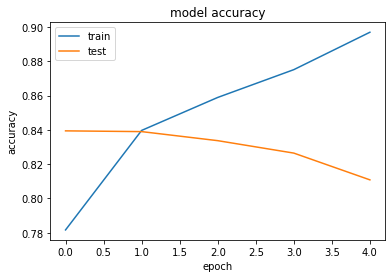

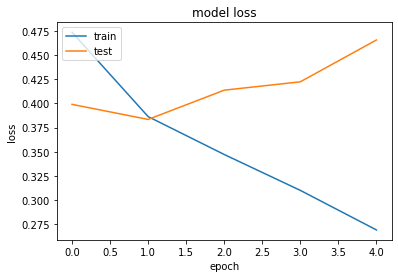

In [19]:
history = model.fit(x_train,  y_train, validation_data=(x_val, y_val), epochs=5, batch_size=216,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [21]:
predictions = model.predict(x_train)
Y = np.where(predictions > 0.5,1,0)

print(sklearn.metrics.classification_report(y_train, Y))

model.save('attention_model')

predictions_val = model.predict(x_val)
Y_val = np.where(predictions_val > 0.5,1,0)

print(sklearn.metrics.classification_report(y_val, Y_val))


              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     10591
         1.0       0.92      0.89      0.90      7621

    accuracy                           0.92     18212
   macro avg       0.92      0.91      0.92     18212
weighted avg       0.92      0.92      0.92     18212

INFO:tensorflow:Assets written to: attention_model\assets
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      2673
         1.0       0.80      0.72      0.76      1879

    accuracy                           0.81      4552
   macro avg       0.81      0.80      0.80      4552
weighted avg       0.81      0.81      0.81      4552



In [20]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)
    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

In [21]:
### na etapie wyciagania spans- dodac, ze jesli klasa 0 to pusty span
def getWordsByAttention(attention, tokenized, word_vect, treshold):
    tokenized = tokenized[0] > 0
    weights = attention[tokenized]
    weights = weights > treshold
    words = [word for k, word in enumerate(word_vect.split(' '))]
    toxic_words = [b for a, b in zip(weights, words) if a]
    return toxic_words

In [22]:



# Create model from word input to output of dense layer right before the attention layer
# print( model.get_layer('time_distributed').output.shape,  len(model.get_layer('dense_final').get_weights()))
hidden_word_encoding_out = Model(inputs=model.input, outputs= model.get_layer('dense').output)
# Load weights from trained attention layer
word_context = model.get_layer('attention').get_weights()
# hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# # Compute context vector using output of dense layer
# ait = wordAttentionWeights(hidden_word_encodings,word_context)
TRESHOLD = 0.010


In [23]:
print(train_df.head(10))

                                            sentence  toxicity_sentence
0  another violent and aggressive immigrant killi...                1.0
1  i am 56 years old, i am not your fucking junio...                1.0
2                what you are saying makes no sense.                0.0
3           i dont know what you are basing this on.                0.0
4  the cheap black market crap is still coming up...                0.0
5  the i5 corridor is still just as busy, and the...                0.0
6  nothing has really changed except that the leg...                0.0
7  and the legal market is controlled by corporat...                0.0
8  the federal government war on drugs really has...                0.0
9  i dont see any glutton of weed, whatever that ...                0.0


In [24]:
for i in range(0,10):
    in_data =data_index[i].reshape(1,MAX_WORD_NUM)
    y = model.predict(in_data)
    print(y)
    Y= np.where(y > 0.5,1,0)
    print(Y)
#     y_pred = np.argmax(Y)
#     print(y_pred)
    if Y == 1 :
        hidden_word_encodings = hidden_word_encoding_out.predict(in_data)
             # Compute context vector using output of dense layer
        ait = wordAttentionWeights(hidden_word_encodings,word_context)
        print(ait)
        toxic = getWordsByAttention(ait,in_data, train_df.iloc[i].sentence,TRESHOLD)
        spans = getSpansByToxicWords(toxic,train_df.iloc[i].sentence)
        
    else :
        toxic = []
        spans = []
    print('attention',(train_df.iloc[i].sentence, toxic, spans))    

[[0.7282828]]
[[1]]
[8.60199798e-03 3.33502479e-02 2.12537870e-03 1.85033605e-02
 3.72060649e-02 5.94350517e-01 2.24114861e-03 1.75565898e-01
 1.22186141e-02 4.06726785e-02 6.52334839e-03 7.33869709e-03
 5.66685162e-02 1.42706768e-03 6.77624077e-04 3.74565629e-04
 2.36461143e-04 1.66008176e-04 1.26606683e-04 1.02908270e-04
 8.78214560e-05 7.77835085e-05 7.08734588e-05 6.59948710e-05
 6.24945751e-05 5.99735031e-05 5.81876629e-05 5.69942567e-05
 5.63226531e-05 5.61597844e-05 5.65470000e-05 5.75849954e-05
 5.94517696e-05 6.24369350e-05 6.70079316e-05 7.39373936e-05
 8.45577306e-05 1.01305006e-04 1.28968633e-04 1.77841008e-04]
attention ('another violent and aggressive immigrant killing a innocent and intelligent us citizen.... sarcasm', ['violent', 'aggressive', 'immigrant', 'killing', 'innocent', 'and', 'intelligent', 'sarcasm'], [8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 5

In [4]:
test_data_semeval = SemEvalData()
data = test_data_semeval.load_data("data/tsd_trial.csv")
test_df_preprocessed = test_data_semeval.preprocess()

In [5]:
# test_df_preprocessed  = test_df_preprocessed.tail(4)


In [6]:
test_df_preprocessed["predicted_span"]=[test_attention(sentences) for sentences in test_df_preprocessed["original_text"] ]

In [7]:
test_df_preprocessed

,spans,text,toxicity,toxic_words,original_text,sentences,diff,toxicity_sentence,predicted_span
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because hes a moron and a bigot. its not any m...,1,"[moron, bigot]",Because he's a moron and a bigot. It's not any...,"[because hes a moron and a bigot., its not any...","[10, 36]","[1.0, 0.0]","[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]"
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let na...,1,[idiots],How about we stop protecting idiots and let na...,[how about we stop protecting idiots and let n...,[],"[1.0, 0.0]","[29, 30, 31, 32, 33, 34]"
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott th...",1,[idiots],"If people were smart, they would Boycott th...","[if people were smart, they would boycott t...",[],[1.0],"[50, 51, 52, 53, 54, 24, 25, 26]"
3,"[87, 88, 89, 90, 91, 92]",trump claimed that russia will never invade th...,1,[stupid],Trump Claimed that Russia will never invade th...,[trump claimed that russia will never invade t...,[],[1.0],"[87, 88, 89, 90, 91, 92]"
4,[],as long as your willing to pay a lot more for ...,0,[],As long as your willing to pay a lot more for ...,[as long as your willing to pay a lot more for...,[148],"[0.0, 0.0, 0.0]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ..."
...,...,...,...,...,...,...,...,...,...
685,"[129, 130, 131, 132, 133, 134]",but ... trumps not bluffing. hes prepared to g...,1,[stupid],But ... Trump's not bluffing. He's prepared to...,"[but ... trumps not bluffing., hes prepared to...","[13, 32, 151, 159, 166]","[0.0, 0.0, 0.0, 1.0, 0.0]","[129, 130, 131, 132, 133, 134]"
686,"[126, 127, 128, 129, 130, 131]",cant believe the limited knowledge of this art...,1,[stupid],Can't believe the limited knowledge of this Ar...,[cant believe the limited knowledge of this ar...,[3],"[0.0, 1.0]","[126, 127, 128, 129, 130, 131]"
687,"[24, 25, 26, 27, 28, 29]",i think it conservative idiots who cannot reac...,1,[idiots],I think it conservative idiots who cannot reac...,[i think it conservative idiots who cannot rea...,[],[1.0],"[24, 25, 26, 27, 28, 29]"
688,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",youre an id*ot...go away.,1,[youre an id*ot],You're an id*ot...Go away.,[youre an id*ot...go away.],[3],[1.0],[]


In [8]:
test_df_preprocessed["Pscore"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(ps) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(ps))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span"]) ]

In [9]:
test_df_preprocessed["Rscore"] = [ 1 if (len(s) == 0 and len(ps) == 0) 
                             else 0 if len(s) == 0 
                             else len( set(s).intersection(set(ps) ))/ len(set(s))  for s, ps in zip(test_df_preprocessed["spans"],test_df_preprocessed["predicted_span"]) ]

In [10]:
test_df_preprocessed["Fscore"] = [ 0 if (p == 0 and r == 0)
    else 2 * p *r /(p + r) for p, r in zip(test_df_preprocessed["Pscore"], test_df_preprocessed["Rscore"] )]

In [11]:
F_score= np.mean(test_df_preprocessed["Fscore"])

In [12]:
F_score

0.47685006434561383